- Download the Retail Data Analytics data from Kaggle here: https://www.kaggle.com/manjeetsingh/retaildataset (Links to an external site.)Links to an external site.. Download the three data sets: one on stores, one on features and one on sales. Merge them and clean the data (deal with missing variables, outliers, etc.).
- Explore the data and perform visualizations you deem appropriate. Make sure to pay attention to the target – the weekly sales -- and how it relates to other features. Do you see some seasonality in the target and, if yes, then what kind?
- Train a model (or models) that predicts the weekly sales in a department store. This is a time series problem so be careful with the train-test split (hint: you do not want to perform a random split here, think about the time horizon). Evaluate the model you have trained and reason about how the store managers can use your forecast to better anticipate sales fluctuations.

In [1]:
#pip install prophet

In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt 
import seaborn as sns
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [3]:
df_features = pd.read_csv('Features data set.csv')
df_sales = pd.read_csv('sales data-set.csv')
df_stores = pd.read_csv('stores data-set.csv')

### Features
Contains additional data related to the store, department, and regional activity for the given dates.

- Store - the store number
- Date - the week
- Temperature - average temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week

In [4]:
df_features.shape

(8190, 12)

In [5]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


In [6]:
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-05-02,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-12-02,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-05-03,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [7]:
df_features.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

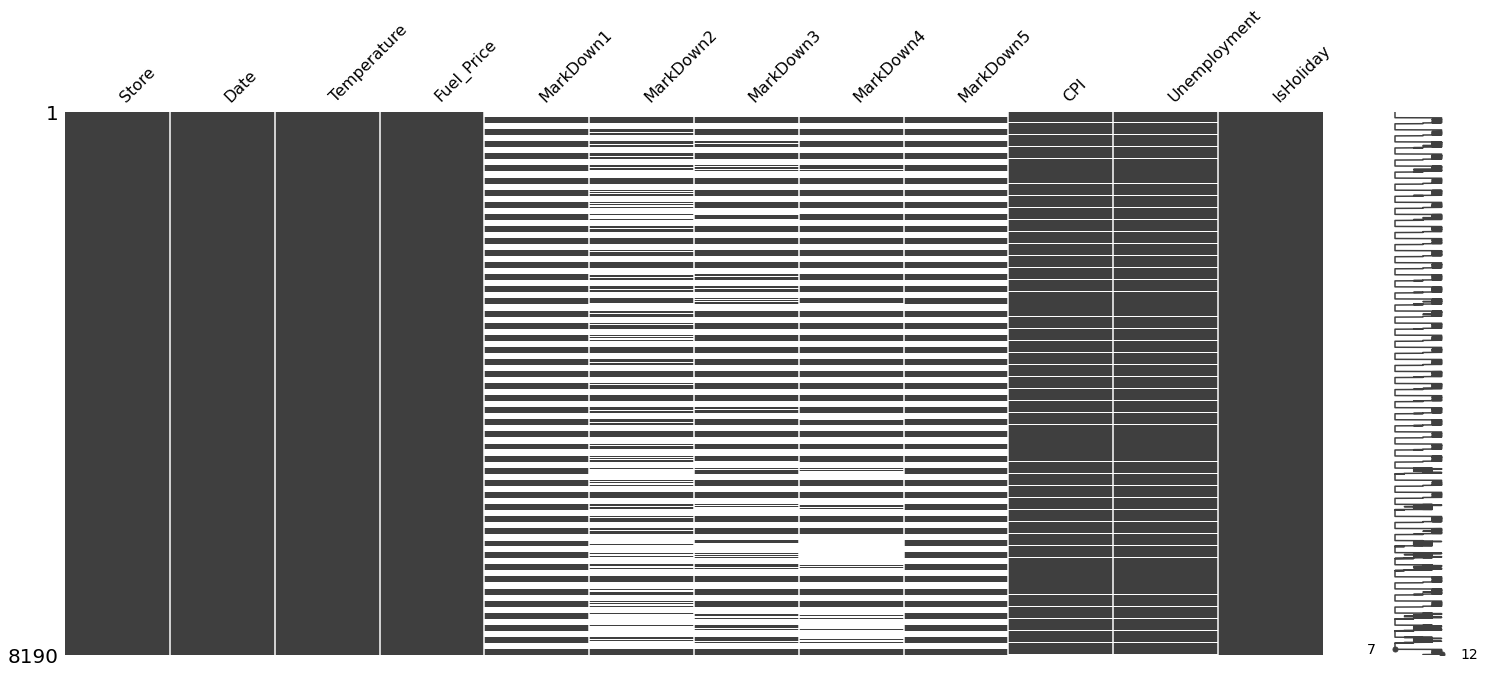

In [8]:
msno.matrix(df_features)

In [9]:
df_features.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
count,8190.000000,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000
mean,23.000000,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821
std,12.987966,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000
25%,12.000000,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000
50%,23.000000,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000
75%,34.000000,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000
max,45.000000,101.950000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000


### Sales
Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:

- Store - the store number
- Dept - the department number
- Date - the week
- Weekly_Sales -  sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week

In [10]:
df_sales.shape

(421570, 5)

In [11]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


In [12]:
df_sales['Date'] = pd.to_datetime(df_sales['Date'])
df_sales.head()                                           

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-05-02,24924.50,False
1,1,1,2010-12-02,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-05-03,21827.90,False


In [13]:
df_sales.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [14]:
df_sales.describe()

,Store,Dept,Weekly_Sales
count,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123
std,12.785297,30.492054,22711.183519
min,1.000000,1.000000,-4988.940000
25%,11.000000,18.000000,2079.650000
50%,22.000000,37.000000,7612.030000
75%,33.000000,74.000000,20205.852500
max,45.000000,99.000000,693099.360000


### Stores
Anonymized information about the 45 stores, indicating the type and size of store

In [15]:
df_stores.shape

(45, 3)

In [16]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [17]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


In [18]:
df_stores['Type'].value_counts()

A    22
B    17
C     6
Name: Type, dtype: int64

In [19]:
print ('Number of stores in Features dataset: ', df_features['Store'].nunique())
print ('Number of stores in Sales dataset: ', df_sales['Store'].nunique())
print ('Number of stores in Stores dataset: ', df_stores['Store'].nunique())

Number of stores in Features dataset:  45
Number of stores in Sales dataset:  45
Number of stores in Stores dataset:  45


In [20]:
# the sales dataset covers the year 2010 to 2012 while features dataset covers 2010 to 2013
print ('Date range in Features dataset :', df_features['Date'].min().strftime('%d-%m-%Y') ,'and', df_features['Date'].max().strftime('%d-%m-%Y'))
print ('Date range in Sales dataset :', df_sales['Date'].min().strftime('%d-%m-%Y') ,'and', df_sales['Date'].max().strftime('%d-%m-%Y'))
print ('Number of records in features dataset outside the range of Sales dataset :', (df_features['Date']>df_sales['Date'].max()).sum())

Date range in Features dataset : 10-01-2010 and 07-12-2013
Date range in Sales dataset : 10-01-2010 and 10-12-2012
Number of records in features dataset outside the range of Sales dataset : 1485


In [21]:
df_features_copy = df_features.copy()
df_sales_copy = df_sales.copy()
df_features_beyond = df_features[df_features['Date']>df_sales['Date'].max()]
print ('Date range in features dataset (beyond Sales dataset) :', df_features_beyond['Date'].min().strftime('%d-%m-%Y') ,'and', df_features_beyond['Date'].max().strftime('%d-%m-%Y'))

Date range in features dataset (beyond Sales dataset) : 14-12-2012 and 07-12-2013


In [22]:
df_features = df_features[df_features['Date']<=df_sales['Date'].max()]

In [23]:
# to test if there are other missing dates - all stores shows 6 days missing! 
df=pd.merge(df_sales,df_features, on=['Store','Date', 'IsHoliday'], how='outer')
df[df['Weekly_Sales'].isna()].groupby('Store')['Store'].count()

Store
1     6
2     6
3     6
4     6
5     6
6     6
7     6
8     6
9     6
10    6
11    6
12    6
13    6
14    6
15    6
16    6
17    6
18    6
19    6
20    6
21    6
22    6
23    6
24    6
25    6
26    6
27    6
28    6
29    6
30    6
31    6
32    6
33    6
34    6
35    6
36    6
37    6
38    6
39    6
40    6
41    6
42    6
43    6
44    6
45    6
Name: Store, dtype: int64

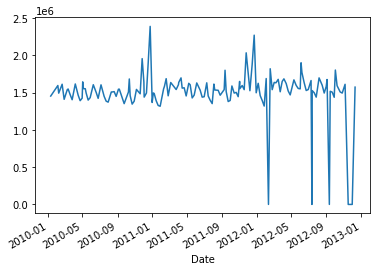

In [24]:
df[df['Store']==1].groupby('Date')['Weekly_Sales'].sum().plot()

In [25]:
# the same 6 days are missing for all the 45 stores -  among the missing dates, 3 dates are in Nov-2012
missing_dates = sorted(df[df['Weekly_Sales'].isna()]['Date'].unique())
missing_dates

[numpy.datetime64('2012-02-11T00:00:00.000000000'),
 numpy.datetime64('2012-07-12T00:00:00.000000000'),
 numpy.datetime64('2012-09-11T00:00:00.000000000'),
 numpy.datetime64('2012-11-16T00:00:00.000000000'),
 numpy.datetime64('2012-11-23T00:00:00.000000000'),
 numpy.datetime64('2012-11-30T00:00:00.000000000')]

In [26]:
# since the data is weekly and having 3 weeks data in Nov-2012 missing could be a problem
df[(df['Date'].dt.month>=10) & (df['Date'].dt.year==2012)].groupby('Date').agg({'Date':'count','Weekly_Sales':'sum'})

,Date,Weekly_Sales
Date,,
2012-10-02,3001,50009407.92
2012-10-08,2957,47403451.04
2012-10-19,2950,45122410.57
2012-10-26,2959,45544116.29
2012-11-05,2973,46925878.99
2012-11-16,45,0.00
2012-11-23,45,0.00
2012-11-30,45,0.00
2012-12-10,2990,46128514.25


In [27]:
# to fix this problem, we will use interpolote for the missing data in Feb, Jul, Sep 2012 & we will drop the data beyond 5-Nov-2012
df_features = df_features_copy.copy()
df_sales = df_sales_copy.copy()

df_features_beyond = df_features[df_features['Date']>'2012-11-5']
df_features = df_features[df_features['Date']<='2012-11-5']
df_sales = df_sales[df_sales['Date']<='2012-11-5']

In [28]:
missing_dates = missing_dates[0:3]
df_missing_dates = pd.DataFrame(missing_dates,columns=['Date'])
df_missing_dates

,Date
0,2012-02-11
1,2012-07-12
2,2012-09-11


In [29]:
df_store_dept = df_sales[['Store','Dept']].drop_duplicates()
df_missing_dates['tmp'] = 1
df_store_dept['tmp'] = 1
df_sales_missing_date = df_store_dept.merge(df_missing_dates, on='tmp', how='outer')
df_sales_missing_date.drop('tmp',axis=1,inplace=True)
df_sales_missing_date.head(10)

,Store,Dept,Date
0,1,1,2012-02-11
1,1,1,2012-07-12
2,1,1,2012-09-11
3,1,2,2012-02-11
4,1,2,2012-07-12
5,1,2,2012-09-11
6,1,3,2012-02-11
7,1,3,2012-07-12
8,1,3,2012-09-11
9,1,4,2012-02-11


In [30]:
df_sales = pd.concat([df_sales,df_sales_missing_date])
df_sales.sort_values(['Store','Dept','Date'], inplace=True)
df_sales['Weekly_Sales'] = df_sales['Weekly_Sales'].interpolate(method ='linear', limit_direction ='forward')

In [31]:
df=pd.merge(df_sales,df_features, on=['Store','Date'], how='outer')
df.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-01-10,20094.19,False,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
1,1,2,2010-01-10,45829.02,False,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
2,1,3,2010-01-10,9775.17,False,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
3,1,4,2010-01-10,34912.45,False,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
4,1,5,2010-01-10,23381.38,False,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False


In [32]:
# Test 'IsHoliday' column
print ("Sales['IsHoliday'] count of null values :", df['IsHoliday_x'].isna().sum())
print ("Sales['IsHoliday'] count of null values :", df['IsHoliday_y'].isna().sum())
print ("Mismatch (not null) : ", (~(df['IsHoliday_x'].isna()) & (df['IsHoliday_x'] != df['IsHoliday_y'])).sum())

Sales['IsHoliday'] count of null values : 9993
Sales['IsHoliday'] count of null values : 0
Mismatch (not null) :  0


In [33]:
# "Sales['IsHoliday'] null values is driven by adding the missing dates - we will drop IsHoliday_x from Sales and keep IsHoliday_y from features
df = df.drop('IsHoliday_x', axis=1)
df.rename(columns={'IsHoliday_y':'IsHoliday'}, inplace=True)
df

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,1,2010-01-10,20094.19,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
1,1,2,2010-01-10,45829.02,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
2,1,3,2010-01-10,9775.17,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
3,1,4,2010-01-10,34912.45,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
4,1,5,2010-01-10,23381.38,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428568,45,93,2012-11-05,3034.74,61.24,3.889,12611.18,NaN,21.36,1667.39,2313.12,190.976417,8.567,False
428569,45,94,2012-11-05,3800.78,61.24,3.889,12611.18,NaN,21.36,1667.39,2313.12,190.976417,8.567,False
428570,45,95,2012-11-05,51925.15,61.24,3.889,12611.18,NaN,21.36,1667.39,2313.12,190.976417,8.567,False
428571,45,97,2012-11-05,6584.52,61.24,3.889,12611.18,NaN,21.36,1667.39,2313.12,190.976417,8.567,False


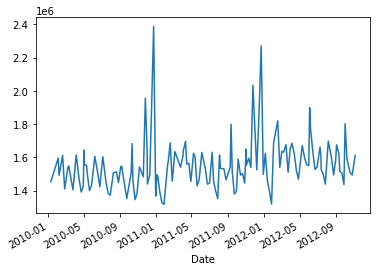

In [34]:
# now we have continuous line for the weekly sales 
df[df['Store']==1].groupby('Date')['Weekly_Sales'].sum().plot()

In [35]:
# merge df with df_store
df=pd.merge(df,df_stores, on=['Store'], how='inner')
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2010-01-10,20094.19,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False,A,151315
1,1,2,2010-01-10,45829.02,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False,A,151315
2,1,3,2010-01-10,9775.17,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False,A,151315
3,1,4,2010-01-10,34912.45,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False,A,151315
4,1,5,2010-01-10,23381.38,71.89,2.603,NaN,NaN,NaN,NaN,NaN,211.671989,7.838,False,A,151315


In [36]:
df.shape

(428573, 16)

In [37]:
df.isna().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
Temperature          0
Fuel_Price           0
MarkDown1       270951
MarkDown2       310663
MarkDown3       284965
MarkDown4       287632
MarkDown5       270138
CPI                  0
Unemployment         0
IsHoliday            0
Type                 0
Size                 0
dtype: int64

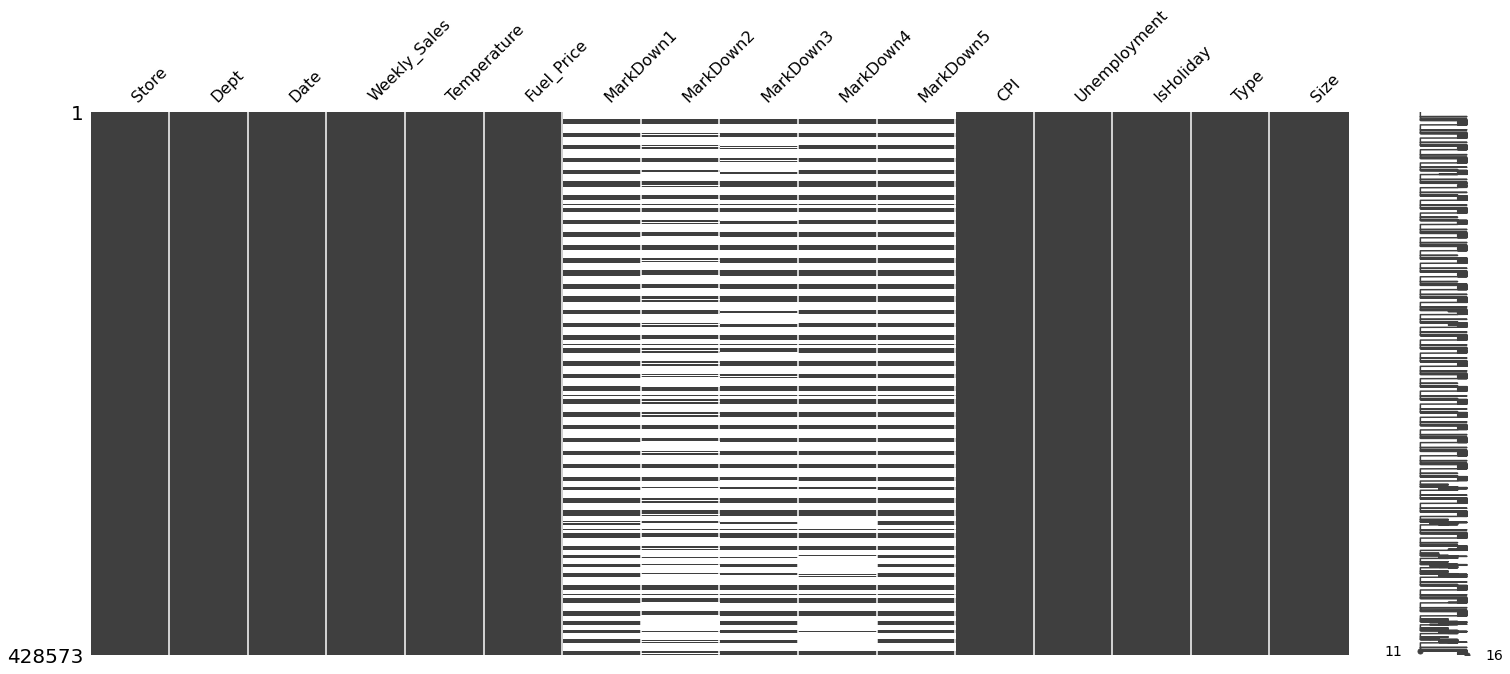

In [38]:
msno.matrix(df)

In [39]:
# we have missing value for all MarkDown features - we will drop them all
df = df.drop(columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4','MarkDown5'],axis = 1)

In [40]:
df.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
IsHoliday       0
Type            0
Size            0
dtype: int64

In [41]:
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2010-01-10,20094.19,71.89,2.603,211.671989,7.838,False,A,151315
1,1,2,2010-01-10,45829.02,71.89,2.603,211.671989,7.838,False,A,151315
2,1,3,2010-01-10,9775.17,71.89,2.603,211.671989,7.838,False,A,151315
3,1,4,2010-01-10,34912.45,71.89,2.603,211.671989,7.838,False,A,151315
4,1,5,2010-01-10,23381.38,71.89,2.603,211.671989,7.838,False,A,151315


In [42]:
# convert IsHoliday to numeric
df['IsHoliday'] = df['IsHoliday'].map({True:1, False:0})
df.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Type,Size
0,1,1,2010-01-10,20094.19,71.89,2.603,211.671989,7.838,0,A,151315
1,1,2,2010-01-10,45829.02,71.89,2.603,211.671989,7.838,0,A,151315
2,1,3,2010-01-10,9775.17,71.89,2.603,211.671989,7.838,0,A,151315
3,1,4,2010-01-10,34912.45,71.89,2.603,211.671989,7.838,0,A,151315
4,1,5,2010-01-10,23381.38,71.89,2.603,211.671989,7.838,0,A,151315


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 428573 entries, 0 to 428572
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         428573 non-null  int64         
 1   Dept          428573 non-null  int64         
 2   Date          428573 non-null  datetime64[ns]
 3   Weekly_Sales  428573 non-null  float64       
 4   Temperature   428573 non-null  float64       
 5   Fuel_Price    428573 non-null  float64       
 6   CPI           428573 non-null  float64       
 7   Unemployment  428573 non-null  float64       
 8   IsHoliday     428573 non-null  int64         
 9   Type          428573 non-null  object        
 10  Size          428573 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(4), object(1)
memory usage: 39.2+ MB


In [44]:
df.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday,Size
count,428573.000000,428573.000000,428573.000000,428573.000000,428573.000000,428573.000000,428573.000000,428573.000000,428573.000000
mean,22.207297,44.291829,15949.736081,59.930311,3.362582,171.289494,7.943797,0.069209,136666.640892
std,12.786361,30.482807,22695.376957,18.390305,0.454984,39.200230,1.863516,0.253809,61001.582023
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,126.064000,3.879000,0.000000,34875.000000
25%,11.000000,18.000000,2058.100000,46.530000,2.938000,132.022667,6.885000,0.000000,93638.000000
50%,22.000000,38.000000,7581.950000,61.900000,3.452000,182.350989,7.866000,0.000000,140167.000000
75%,33.000000,74.000000,20155.620000,74.140000,3.737000,212.592862,8.567000,0.000000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.449000,227.456446,14.313000,1.000000,219622.000000


### Data Visualization 

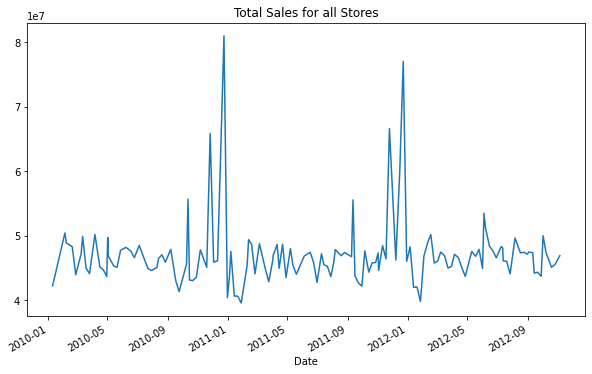

In [45]:
# weekly sales trend for the 3 years period - clear 3 spikes in sales Sep (maybe schools), Nov (Black Friday) & Dec (Chrismas) 
df.groupby('Date')['Weekly_Sales'].sum().plot(figsize=(10,6), title='Total Sales for all Stores')

[Text(0, 0, '2009-07'),
 Text(0, 0, '2010-01'),
 Text(0, 0, '2010-08'),
 Text(0, 0, '2011-03'),
 Text(0, 0, '2011-09'),
 Text(0, 0, '2012-04'),
 Text(0, 0, '2012-10'),
 Text(0, 0, '2013-05')]

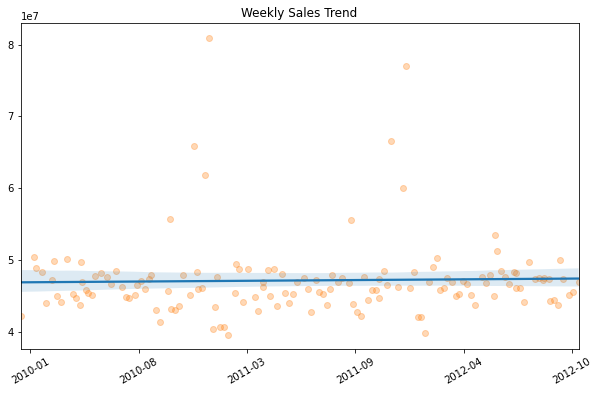

In [46]:
from matplotlib.dates import date2num, num2date
df['NDate'] = date2num( df['Date'])

fig,ax = plt.subplots(figsize=(10,6))

sns.regplot(x='NDate', y='Weekly_Sales', data=df.groupby('NDate')['Weekly_Sales'].sum().reset_index(), ax=ax, scatter_kws={'alpha':0.3,'color':'C1'}, order=1)
ax.set_title('Weekly Sales Trend')
ax.set_xlabel('')
ax.set_ylabel('')
xticks = ax.get_xticks()
xticks_dates = [num2date(x).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates,rotation=30)


In [47]:
slope ,intercept = np.polyfit(df['NDate'], df['Weekly_Sales'],deg=1)
print ('slope: ' ,slope)
print ('intercept: ' ,intercept)

slope:  -0.24489271291576745
intercept:  195777.35104145386


In [48]:
# Weekly Sales by Type
dfs = df.groupby(['Type','Date'])['Weekly_Sales'].sum().reset_index()
dfs.head()

,Type,Date,Weekly_Sales
0,A,2010-01-10,27265424.16
1,A,2010-02-04,32314949.92
2,A,2010-02-07,31238640.48
3,A,2010-02-19,31000072.76
4,A,2010-02-26,28008995.99


Text(0.5, 1.0, 'Total Sales by Store Type')

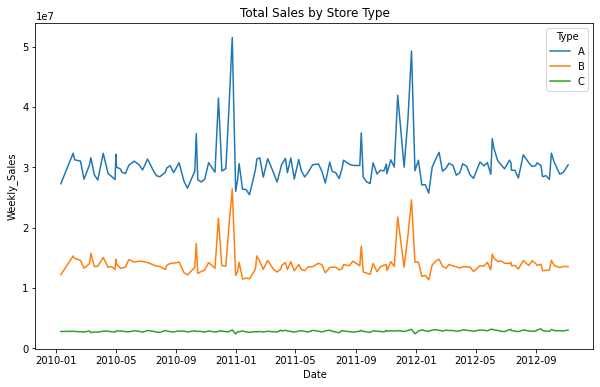

In [49]:
# Type A shows highest sales followed by Type B then C - Type A & B shows the same seasonality trend by Type C is almost flat
plt.subplots(figsize=(10,6))
ax = sns.lineplot(x='Date', y='Weekly_Sales', data=dfs, hue='Type')
ax.set_title('Total Sales by Store Type')

Text(0.5, 0, '')

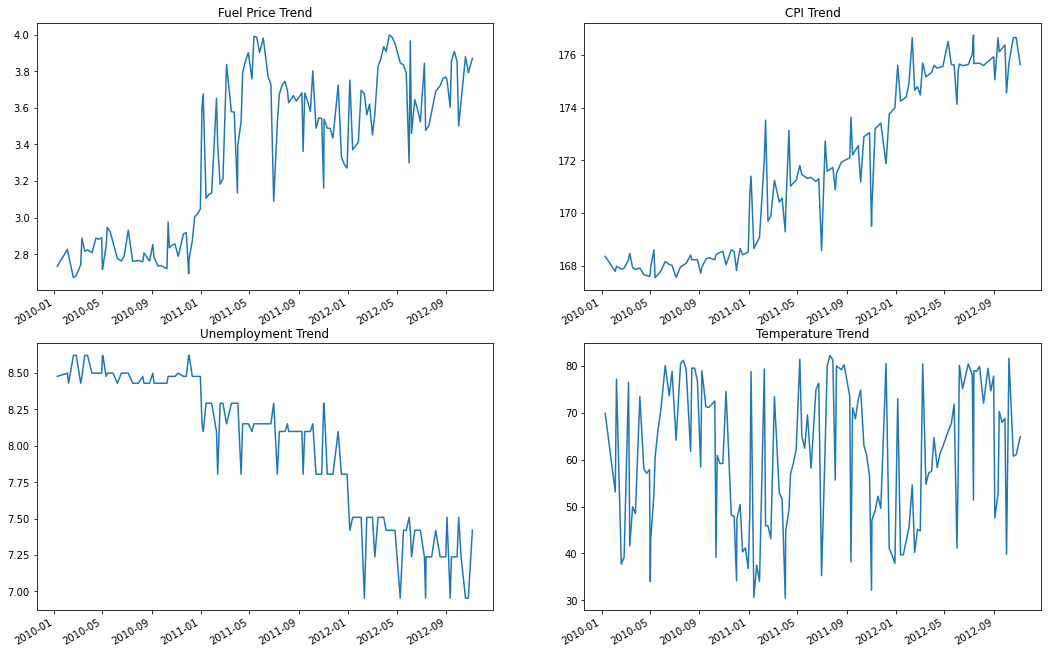

In [50]:
# now we look at the other factors
fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12)) 
df_features.groupby('Date')['Fuel_Price'].mean().plot(ax=axes[0,0])
df_features.groupby('Date')['Unemployment'].mean().plot(ax=axes[1,0])
df_features.groupby('Date')['CPI'].mean().plot(ax=axes[0,1])
df_features.groupby('Date')['Temperature'].mean().plot(ax=axes[1,1])

axes[0,0].set_title('Fuel Price Trend')
axes[1,0].set_title('Unemployment Trend')
axes[0,1].set_title('CPI Trend')
axes[1,1].set_title('Temperature Trend')

axes[0,0].set_xlabel('')
axes[1,0].set_xlabel('')
axes[0,1].set_xlabel('')
axes[1,1].set_xlabel('')

Fuel price has increased over the 3 years period while unemployment rate has dropped

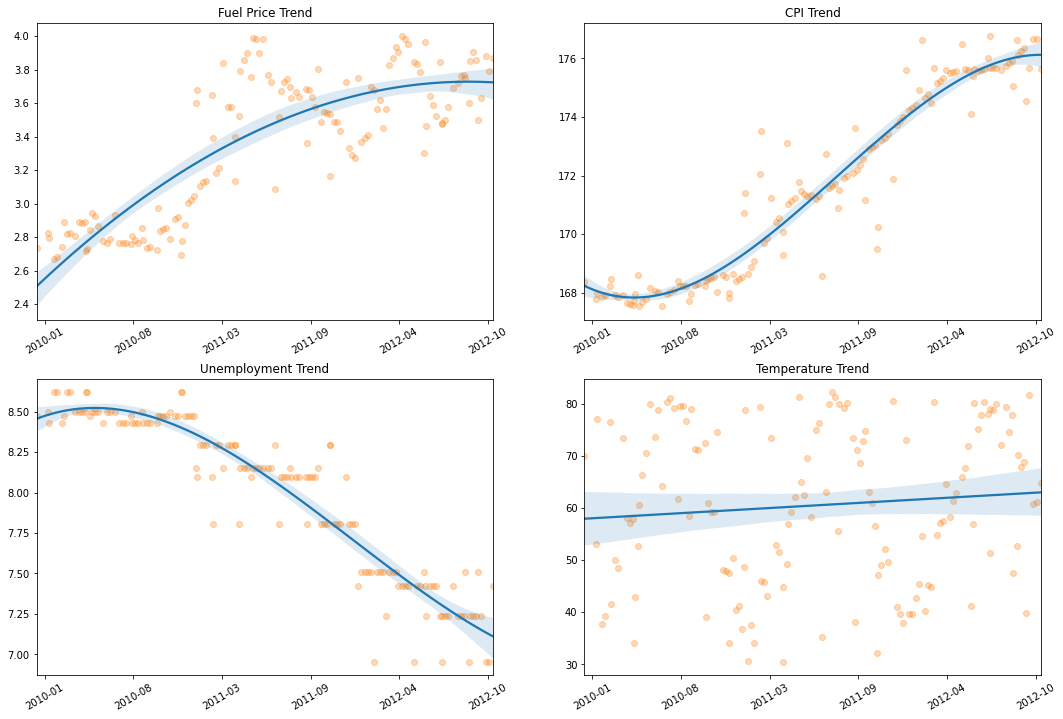

In [51]:
from matplotlib.dates import date2num, num2date
df_features['NDate'] = date2num( df_features['Date'])

fig,axes = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

sns.regplot(x='NDate', y='Fuel_Price', data=df_features.groupby('NDate')['Fuel_Price'].mean().reset_index(), ax=axes[0,0], scatter_kws={'alpha':0.3,'color':'C1'}, order=2)
sns.regplot(x='NDate', y='Unemployment', data=df_features.groupby('NDate')['Unemployment'].mean().reset_index(), ax=axes[1,0], scatter_kws={'alpha':0.3,'color':'C1'}, order=3)
sns.regplot(x='NDate', y='CPI', data=df_features.groupby('NDate')['CPI'].mean().reset_index(),ax=axes[0,1], scatter_kws={'alpha':0.3,'color':'C1'}, order=3)
sns.regplot(x='NDate', y='Temperature', data=df_features.groupby('NDate')['Temperature'].mean().reset_index(), ax=axes[1,1], scatter_kws={'alpha':0.3,'color':'C1'}, order=1)

axes[0,0].set_title('Fuel Price Trend')
axes[1,0].set_title('Unemployment Trend')
axes[0,1].set_title('CPI Trend')
axes[1,1].set_title('Temperature Trend')

for i in range(2):
  for j in range(2):
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')
    xticks = axes[i,j].get_xticks()
    xticks_dates = [num2date(x).strftime('%Y-%m') for x in xticks]
    axes[i,j].set_xticklabels(xticks_dates,rotation=30)


The above charts show clearly the fuel price along with CPI and Temperature while the unemployment is dropping 

Text(0.5, 0, '')

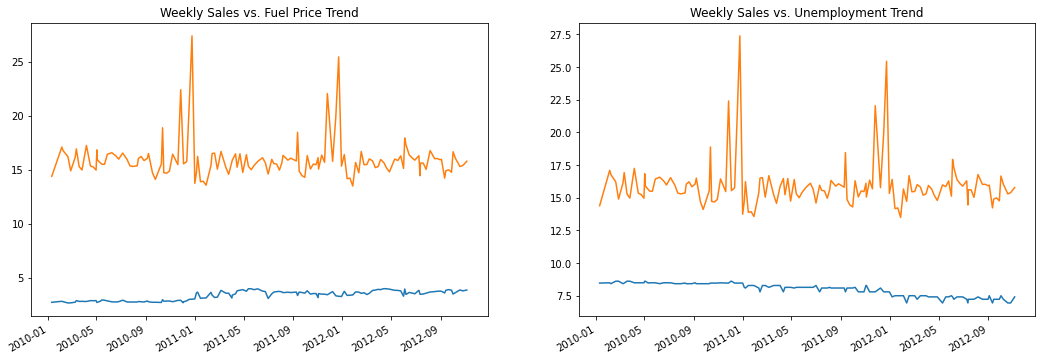

In [52]:
# Average Weekly Sales vs. Fuel_Price & Unemployment
fig,axes = plt.subplots(ncols=2, figsize=(18,6)) 
df_features.groupby('Date')['Fuel_Price'].mean().plot(ax=axes[0])
df_features.groupby('Date')['Unemployment'].mean().plot(ax=axes[1])

(df.groupby('Date')['Weekly_Sales'].mean()/1000).plot(ax=axes[0])
(df.groupby('Date')['Weekly_Sales'].mean()/1000).plot(ax=axes[1])

axes[0].set_title('Weekly Sales vs. Fuel Price Trend')
axes[1].set_title('Weekly Sales vs. Unemployment Trend')

axes[0].set_xlabel('')
axes[1].set_xlabel('')


### Data Modeling using FB-Prophet

Trying simple model by using date and weekly sales only

In [53]:
# assuming Store 1 
df1 = df[df['Store']==1].groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df1 = df1.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})
df1.head()

,ds,y
0,2010-01-10,1453329.50
1,2010-02-04,1594968.28
2,2010-02-07,1492418.14
3,2010-02-19,1611968.17
4,2010-02-26,1409727.59


In [54]:
m = Prophet(seasonality_mode="multiplicative")
m.fit(df1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [55]:
dff = m.make_future_dataframe(periods=112,freq='W')
dff.head()

,ds
0,2010-01-10
1,2010-02-04
2,2010-02-07
3,2010-02-19
4,2010-02-26


In [56]:
dff.tail()

,ds
252,2014-11-30
253,2014-12-07
254,2014-12-14
255,2014-12-21
256,2014-12-28


In [57]:
df_future = m.predict(dff)
df_future.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2010-01-10,1.519278e+06,1.281395e+06,1.563559e+06,1.519278e+06,1.519278e+06,-0.060388,-0.060388,-0.060388,0.024576,0.024576,0.024576,-0.084964,-0.084964,-0.084964,0.0,0.0,0.0,1.427532e+06
1,2010-02-04,1.523365e+06,1.423989e+06,1.700654e+06,1.523365e+06,1.523365e+06,0.026895,0.026895,0.026895,-0.003367,-0.003367,-0.003367,0.030262,0.030262,0.030262,0.0,0.0,0.0,1.564337e+06
2,2010-02-07,1.523856e+06,1.502837e+06,1.780804e+06,1.523856e+06,1.523856e+06,0.081012,0.081012,0.081012,0.024576,0.024576,0.024576,0.056436,0.056436,0.056436,0.0,0.0,0.0,1.647307e+06
3,2010-02-19,1.525818e+06,1.393554e+06,1.676321e+06,1.525818e+06,1.525818e+06,0.003493,0.003493,0.003493,-0.043934,-0.043934,-0.043934,0.047427,0.047427,0.047427,0.0,0.0,0.0,1.531148e+06
4,2010-02-26,1.526963e+06,1.342472e+06,1.624359e+06,1.526963e+06,1.526963e+06,-0.029534,-0.029534,-0.029534,-0.043934,-0.043934,-0.043934,0.014400,0.014400,0.014400,0.0,0.0,0.0,1.481865e+06


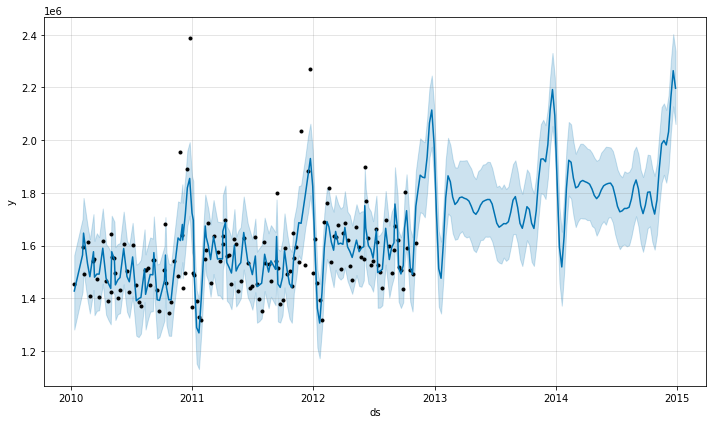

In [58]:
m.plot(df_future);

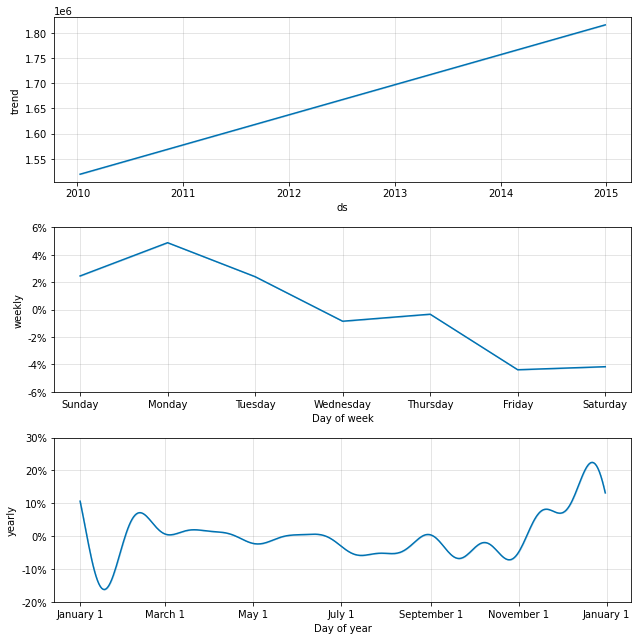

In [59]:
m.plot_components(df_future);

Using cross_validation to split the date and check the accuracy of the model

In [60]:
df_cv = cross_validation(m, initial='366 days', period='366 days', horizon = '366 days', parallel='processes' )

INFO:prophet:Making 1 forecasts with cutoffs between 2011-11-05 00:00:00 and 2011-11-05 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f12fbda8bd0>


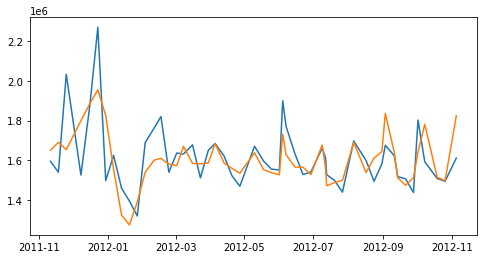

In [61]:
plt.subplots(figsize=(8,4))
plt.plot(df_cv['ds'],df_cv['y'], label='actual')
plt.plot(df_cv['ds'],df_cv['yhat'], label='forecast')

In [62]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,41 days,4.909294e+10,221569.267562,173071.120787,0.100387,0.097790,0.100252,0.4
1,48 days,6.836497e+10,261466.963093,225059.221825,0.121221,0.138896,0.123278,0.2
2,55 days,8.532401e+10,292102.745847,260511.905085,0.145445,0.179679,0.144095,0.2
3,62 days,5.737607e+10,239533.029771,198415.304365,0.116634,0.138896,0.111613,0.4
4,69 days,4.602822e+10,214541.887161,170705.514783,0.099263,0.092825,0.098108,0.4


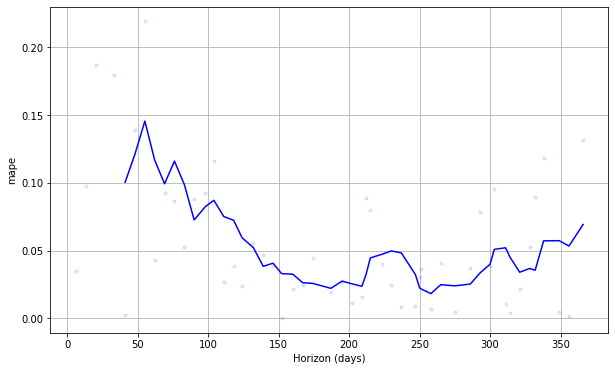

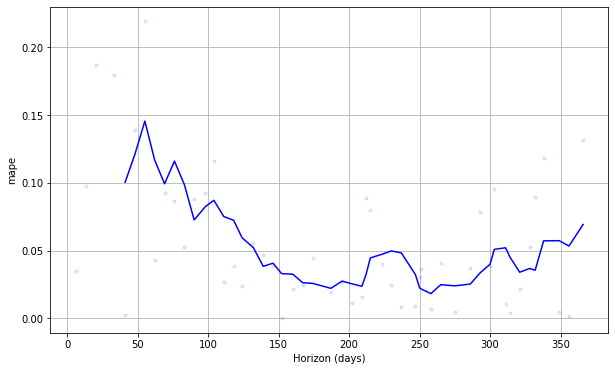

In [63]:
plot_cross_validation_metric(df_cv,metric="mape")

Rerun the same model after adding other features into the model (Fuel price, CPI & Unemplyment) and try different parameter for the Prophet model

In [64]:
# assuming Store 1 
df1 = df[df['Store']==1].groupby(by=['Date'], as_index=False).agg({'Weekly_Sales':'sum', 'Fuel_Price':'mean', 'CPI':'mean', 'Unemployment':'mean'})
df1 = df1.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})
df1.head()

,ds,y,Fuel_Price,CPI,Unemployment
0,2010-01-10,1453329.50,2.603,211.671990,7.838
1,2010-02-04,1594968.28,2.719,210.820450,7.808
2,2010-02-07,1492418.14,2.669,211.223533,7.787
3,2010-02-19,1611968.17,2.514,211.289143,8.106
4,2010-02-26,1409727.59,2.561,211.319643,8.106


In [65]:
df_holiday = pd.DataFrame(df[df['IsHoliday']==True]['Date'].unique(), columns=['ds'])
df_holiday['holiday'] = 'holiday'
df_holiday

,ds,holiday
0,2010-10-09,holiday
1,2010-11-26,holiday
2,2010-12-02,holiday
3,2010-12-31,holiday
4,2011-09-09,holiday
5,2011-11-02,holiday
6,2011-11-25,holiday
7,2011-12-30,holiday
8,2012-07-09,holiday
9,2012-10-02,holiday


In [66]:
import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode' : ['additive','multiplicative'],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params,holidays=df_holiday)
    m.add_regressor('Unemployment')
    m.add_regressor('CPI')
    m.add_regressor('Fuel_Price')
    m.fit(df1)  # Fit model with given params
    df_cv = cross_validation(m, initial='366 days', period='180 days', horizon='180 days',parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2011-05-15 00:00:00 and 2012-05-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f12fbf48610>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2011-05-15 00:00:00 and 2012-05-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f12ff49bad0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 3 forecasts with cutoffs between 2011-05-15 00:00:00 and 2012-05-09 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f12ff402fd0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seaso

    changepoint_prior_scale  ...           rmse
0                     0.001  ...  131885.162174
1                     0.001  ...  142046.465055
2                     0.001  ...  144388.433319
3                     0.001  ...  145483.080524
4                     0.001  ...  141317.704093
5                     0.001  ...  146478.400131
6                     0.001  ...  141260.465254
7                     0.001  ...  145793.140829
8                     0.010  ...  130062.936395
9                     0.010  ...  140020.609281
10                    0.010  ...  133590.088053
11                    0.010  ...  134097.560851
12                    0.010  ...  142479.437377
13                    0.010  ...  134290.652456
14                    0.010  ...  141986.217106
15                    0.010  ...  134471.605402
16                    0.100  ...  130870.845016
17                    0.100  ...  139140.340008
18                    0.100  ...  142876.292472
19                    0.100  ...  144774

In [67]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


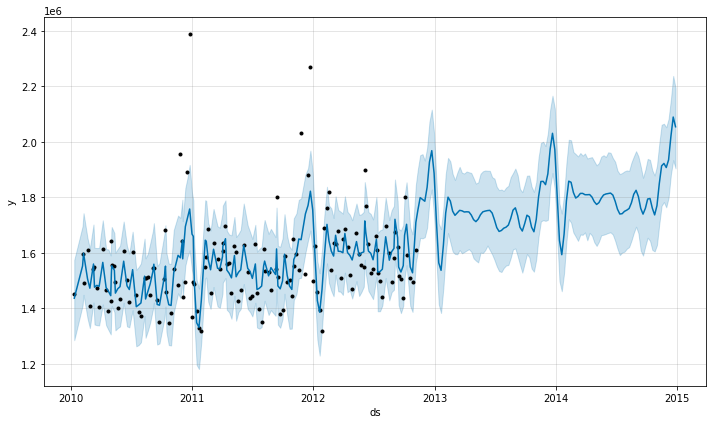

In [68]:
m = Prophet(**best_params).fit(df1)
df_future = m.predict(dff)
m.plot(df_future);

In [69]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,16 days,2.219708e+10,148986.838190,102657.561809,0.059693,0.038573,0.060719,0.714286
1,21 days,2.196937e+10,148220.690855,98292.292548,0.057104,0.038573,0.058176,0.714286
2,23 days,2.024862e+10,142297.643767,84213.698880,0.047153,0.009278,0.048640,0.714286
3,26 days,2.272712e+10,150755.156837,91426.151396,0.048371,0.009278,0.051287,0.714286
4,27 days,3.211176e+10,179197.536207,125987.080331,0.071093,0.038573,0.072136,0.571429


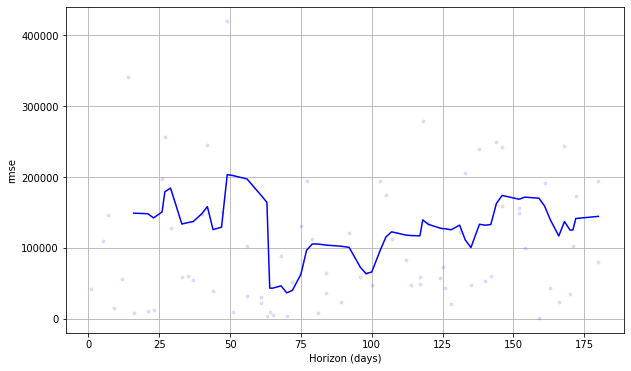

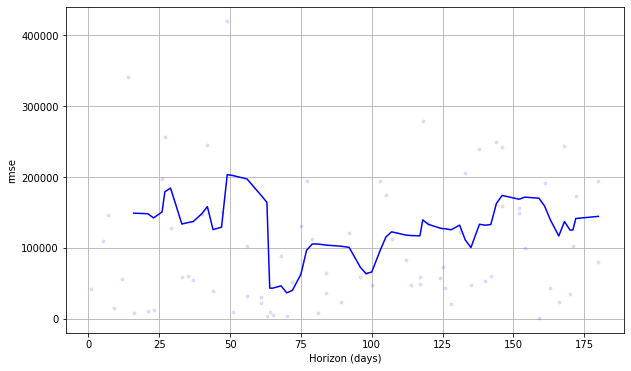

In [70]:
plot_cross_validation_metric(df_cv,metric="rmse")

### Data Modeling using AR & MA

In [71]:
# assuming Store 1 
df1 = df[df['Store']==1].groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df1 = df1.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})
df1.set_index('ds', inplace=True)
df1.index = df1.index.to_period('W')
df1.head()

,y
ds,
2010-01-04/2010-01-10,1453329.50
2010-02-01/2010-02-07,1594968.28
2010-02-01/2010-02-07,1492418.14
2010-02-15/2010-02-21,1611968.17
2010-02-22/2010-02-28,1409727.59


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



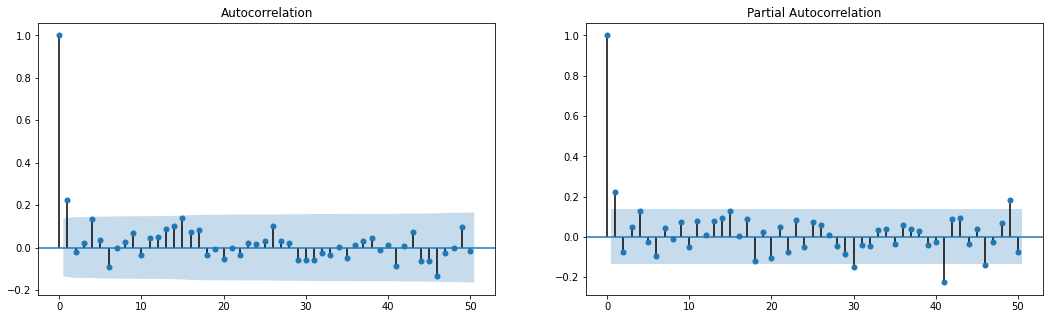

In [72]:
from statsmodels.graphics.tsaplots import acf, pacf, plot_acf, plot_pacf

# plotting auto correlation and partial correlation
fig, axes = plt.subplots(1,2, figsize=(18,5))
plot_acf(df1.values, lags=50, alpha=0.1, ax=axes[0])
plot_pacf(df1.values, lags=50, alpha=0.1, ax=axes[1])
plt.show()

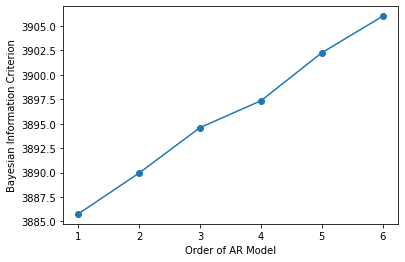

In [73]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(7)
for p in range(7):
    mod = ARMA(df1, order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,7), BIC[1:7], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Bayesian Information Criterion')
plt.show()

In [74]:
# Fit an AR(1) model 
mod = ARMA(df1, order=(1,0))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print(res.params)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  145
Model:                     ARMA(1, 0)   Log Likelihood               -1935.417
Method:                       css-mle   S.D. of innovations         151537.484
Date:                Sun, 20 Jun 2021   AIC                           3876.833
Time:                        18:12:21   BIC                           3885.764
Sample:                    01-10-2010   HQIC                          3880.462
                         - 11-11-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.557e+06   1.62e+04     96.433      0.000    1.53e+06    1.59e+06
ar.L1.y        0.2223      0.081      2.752      0.007       0.064       0.381
                                    Roots           

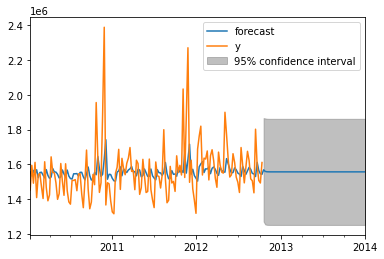

In [75]:
res.plot_predict(start=0,end='2014')
plt.show()

In [76]:
# Fit an MA(1) model 
mod = ARMA(df1, order=(0,1))
res = mod.fit()

# Print out summary information on the fit
print(res.summary())

# Print out the estimate for the constant and for phi
print(res.params)

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  145
Model:                     ARMA(0, 1)   Log Likelihood               -1935.030
Method:                       css-mle   S.D. of innovations         151128.452
Date:                Sun, 20 Jun 2021   AIC                           3876.060
Time:                        18:12:22   BIC                           3884.990
Sample:                    01-10-2010   HQIC                          3879.689
                         - 11-11-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.557e+06   1.56e+04     99.939      0.000    1.53e+06    1.59e+06
ma.L1.y        0.2434      0.081      3.019      0.003       0.085       0.401
                                    Roots           

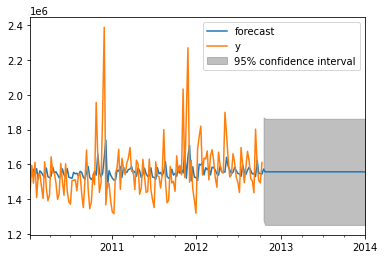

In [77]:
res.plot_predict(start=0,end='2014')
plt.show()

Using ARIMA + Split data

In [78]:
# assuming Store 1 
df1 = df[df['Store']==1].groupby(by=['Date'], as_index=False)['Weekly_Sales'].sum()
df1 = df1.rename(columns = {'Date':'ds', 'Weekly_Sales':'y'})
df1.set_index('ds', inplace=True)
#df1.index = df1.index.to_period('W')
df1.head()

,y
ds,
2010-01-10,1453329.50
2010-02-04,1594968.28
2010-02-07,1492418.14
2010-02-19,1611968.17
2010-02-26,1409727.59


In [79]:
# Create Training and Test
train = df1[:100]
test = df1[100:]

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available



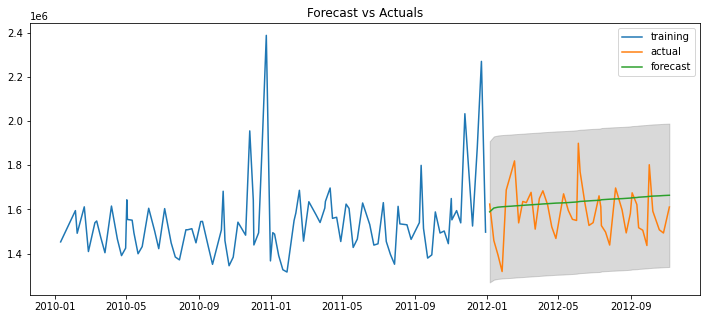

In [80]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(45, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5))
plt.plot(train['y'], label='training')
plt.plot(test['y'], label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper right')
plt.show()
